In [1]:
# %%
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.io import loadmat
from torch.distributions import MultivariateNormal, Bernoulli
from cutbayesflow import CutBayesFlow, train_cut_bayes_flow
from cutbayesflow.utils import get_marginal_samples

# Get directory of current script
base_dir = os.getcwd()

# ─────────────────────────────────────────────
# Set seed & parameters
# ─────────────────────────────────────────────
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

n_samples = 1000
dim_theta = 6  # [beta0, beta1, gamma2, gamma3, gamma4, gamma5]
hidden_dim = 128
num_layers = 8
num_bins = 15
tail_bound = 15.0
learning_rate = 5e-4
epochs = 1000
batch_size = n_samples

# ─────────────────────────────────────────────
# Load data
# ─────────────────────────────────────────────
X_vec = loadmat(os.path.join(base_dir, "simdata", "Xvec.mat"))['mat']
Z_vec = loadmat(os.path.join(base_dir, "simdata", "Zvec.mat"))['mat']
q_mat = loadmat(os.path.join(base_dir, "stage1", "q1.mat"))['mat']

X_t = torch.tensor(X_vec[seed, :], dtype=torch.float32).view(1, -1).repeat(n_samples, 1)  # [1000, 1000]
Z_t = torch.tensor(Z_vec[seed, :], dtype=torch.float32).view(1, -1).repeat(n_samples, 1)  # [1000, 1000]
q_t = torch.tensor(q_mat[:, :, 1:], dtype=torch.float32)  # [1000, 1000, 4]
q_flat = q_t.reshape(n_samples, -1)  # [1000, 4000]
p_eta = q_flat.shape[1]

# Bundle additional data needed for likelihood
data_D2 = {
    "X": X_t,     # [1000, 1000]
    "Z": Z_t,     # [1000, 1000]
    "q": q_t      # [1000, 1000, 4]
}

# ─────────────────────────────────────────────
# Define likelihood log-probability function
# ─────────────────────────────────────────────
def likelihood_log_prob_fn(theta, eta, data):
    """
    log p(Z | theta, q, X) where Z ~ Bernoulli(sigmoid(beta0 + beta1*X + q*gamma))
    theta: [N, dim_theta], eta: [N, p_eta]
    data: dict with 'X', 'Z', and 'q'
    """
    X, Z, q = data["X"], data["Z"], data["q"]
    N = theta.shape[0]
    beta0 = theta[:, 0].unsqueeze(1)  # [N, 1]
    beta1 = theta[:, 1].unsqueeze(1)  # [N, 1]
    gamma = theta[:, 2:].unsqueeze(1)  # [N, 1, 4]

    # η_i = beta0 + beta1 * X + sum_k gamma_k * q_k
    sum_q_gamma = (q * gamma).sum(dim=2)  # [N, n_indiv]
    logits = beta0 + beta1 * X + sum_q_gamma  # [N, n_indiv]
    probs = torch.sigmoid(logits)

    # log p(Z | logits)
    bernoulli = Bernoulli(probs)
    log_likelihood = bernoulli.log_prob(Z).sum(dim=1)  # [N]
    return log_likelihood

# ─────────────────────────────────────────────
# Define prior log-probability function
# ─────────────────────────────────────────────
def prior_log_prob_fn(theta):
    """
    Multivariate Normal prior over theta ~ N(0, diag([800, 50, 50, 50, 50, 50]))
    """
    prior_std = torch.sqrt(torch.tensor([800.] + [50.] * 5, dtype=torch.float32))
    scale_tril = torch.diag(prior_std)
    dist = MultivariateNormal(torch.zeros(dim_theta), scale_tril=scale_tril)
    return dist.log_prob(theta)

# ─────────────────────────────────────────────
# Initialize CutBayesFlow model
# ─────────────────────────────────────────────
model = CutBayesFlow(
    prior_log_prob_fn=prior_log_prob_fn,
    likelihood_log_prob_fn=likelihood_log_prob_fn,
    eta_dim=p_eta,
    theta_dim=dim_theta,
    num_layers=num_layers,
    hidden_features=hidden_dim,
    num_bins=num_bins,
    tail_bound=tail_bound
)

# ─────────────────────────────────────────────
# Train model
# ─────────────────────────────────────────────
print("Training CutBayesFlow on propensity score simulation...")
loss_history = train_cut_bayes_flow(
    model=model,
    eta_samples=q_flat,
    data_D2=data_D2,  # Pass all required data here
    epochs=epochs,
    lr=learning_rate,
    seed=1010,
    verbose=100  # Print every 50 steps
)


Training CutBayesFlow on propensity score simulation...
⚡ Using full-batch mode with batch_size=1000
Step     0 | Loss: -5091.143066
Step   100 | Loss: -7846.161621
Step   200 | Loss: -7799.805176
Step   300 | Loss: -7888.185547
Step   400 | Loss: -7927.309082
Step   500 | Loss: -7919.584961
Step   600 | Loss: -7823.441895
Step   700 | Loss: -7907.286133
Step   800 | Loss: -7782.332520
Step   900 | Loss: -7869.533691
Step   999 | Loss: -7861.666992


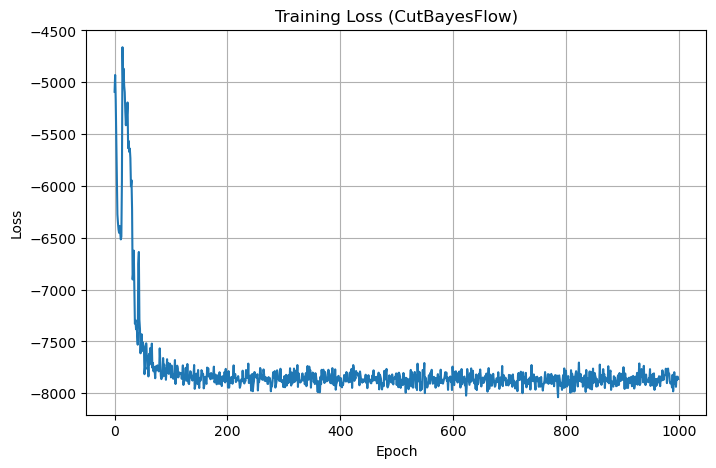

In [2]:
# ─────────────────────────────────────────────
# Plot training loss
# ─────────────────────────────────────────────
plt.figure(figsize=(8, 5))
plt.plot(loss_history)
plt.title("Training Loss (CutBayesFlow)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()



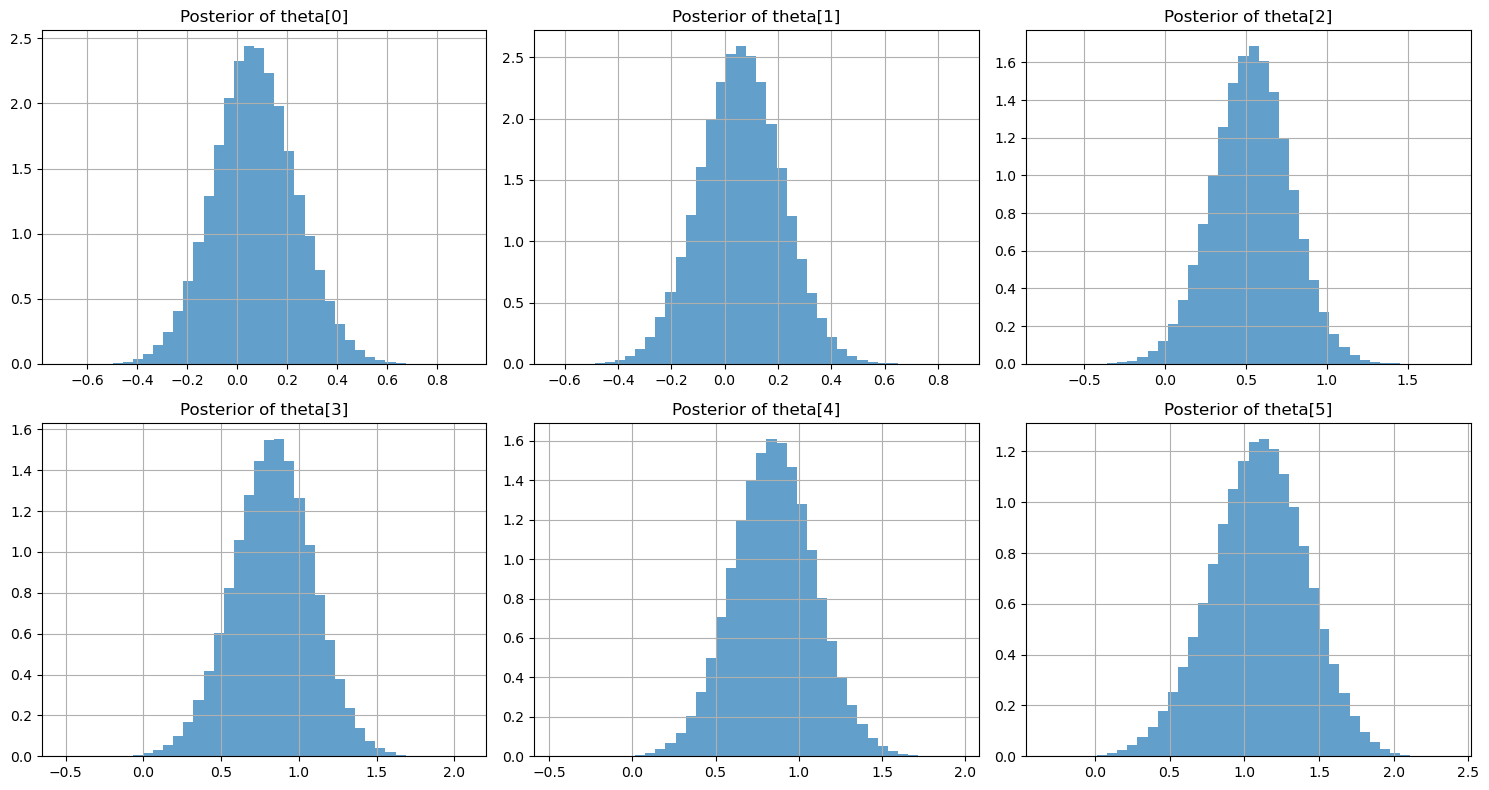

In [3]:
# ─────────────────────────────────────────────
# Generate marginal samples of theta
# ─────────────────────────────────────────────

n_iterations = 1000

theta_samples_q = get_marginal_samples(model, q_flat, n_iterations=n_iterations)
theta_samples_q_flat = theta_samples_q.reshape(-1, dim_theta).cpu().numpy()

# Plot histograms for each parameter theta_k
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i in range(dim_theta):
    axes[i].hist(theta_samples_q_flat[:, i], bins=40, density=True, alpha=0.7)
    axes[i].set_title(f"Posterior of theta[{i}]")
    axes[i].grid(True)
plt.tight_layout()
plt.show()
